In [81]:
from dotenv import load_dotenv
load_dotenv()

True

In [82]:
FORBIDDEN_TOPICS = ["violence", "murder", "sex", "drugs", "death", "blood", "war"]

@tool
def fetch_story(topic: str) -> str:
    """Returns a short story based on the given topic."""
    stories = {
        "sharing": "Benny the bunny shared his carrots and made everyone happy!",
        "kindness": "Lila helped an old man and started a kindness club!",
        "honesty": "Omar admitted his mistake and became trustworthy.",
        "violence": "Warriors fought in blood-soaked battles... (🚫 not for kids!)"
    }
    return stories.get(topic.lower(), "Sorry, no story is available for this topic.")

In [83]:
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(model="gemini-2.5-flash").bind_tools([fetch_story])

In [63]:
def moderate_topic_node(state):
    question = state["messages"][-1].content
    prompt = (
        f"Return `true` if the following question is about any of these topics: "
        f"{', '.join(FORBIDDEN_TOPICS)}. Else return False.\n\nQuestion: {question}"
    )
    result = model.invoke(prompt).content.strip().lower()
    return {"messages": state["messages"] + [AIMessage(content=result)]}

In [64]:
def route_after_moderation(state):
    result = state["messages"][-1].content.strip().lower()
    if "true" in result:
        return "reject_story_node"
    return "generate_story"

In [65]:
def generate_story(state):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": response}

In [66]:
def should_continue(state):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "call_tool"
    return "human_review_node"

In [ ]:
def route_after_tool(state):
    story = state["messages"][-1].content.lower()
    if any(word in story for word in FORBIDDEN_TOPICS):
        return "reject_story_node"
    return "human_review_node"


def reject_story_node(state):
    if state["messages"][-1].content == "Story rejected by human":
        return {
            "messages": ["❌ "] + [state["messages"][-1]]
        }
    else:
        return {
            "messages": [
                AIMessage(content="❌ This topic is not suitable for kids and has been rejected.")
            ]
        }

In [74]:
from langgraph.types import Command, interrupt

def human_review_node(state):
    last_message = state["messages"][-1]
    review = interrupt({
        "question": "Do you want to publish this story?",
        "story": last_message
    })

    action = review["action"]
    data = review.get("data")
    if action == "publish":
        print("published!")
        return Command(goto=END)
    elif action == "reject":
        return Command(goto=END, update={
            "messages": state["messages"] + [AIMessage(content="❌ Story rejected by human.")]
        })

In [75]:
from langgraph.graph import StateGraph, MessagesState, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

builder = StateGraph(MessagesState)

tools = ToolNode(tools=[fetch_story])

builder.add_node("moderate_topic", moderate_topic_node)
builder.add_node("call_tool", tools)
builder.add_node("reject_story_node", reject_story_node)
builder.add_node("human_review_node", human_review_node)
builder.add_node("generate_story", generate_story)

builder.set_entry_point("moderate_topic")
builder.add_conditional_edges("moderate_topic", route_after_moderation, {"reject_story_node":"reject_story_node", "generate_story":"generate_story"})
builder.add_conditional_edges("generate_story", should_continue, {"call_tool":"call_tool", "human_review_node":"human_review_node"})

builder.add_edge("call_tool", "generate_story")

builder.add_edge("reject_story_node", END)

graph = builder.compile(checkpointer=MemorySaver())

In [76]:
from langchain_core.messages import HumanMessage

input = {"messages": [HumanMessage(content="Tell me a story about sharing")]}
config = {"configurable": {"thread_id": "kid-story-1"}}
graph.invoke(input, config=config, stream_mode="updates")

[{'moderate_topic': {'messages': [HumanMessage(content='Tell me a story about sharing', additional_kwargs={}, response_metadata={}, id='8e51b35c-0493-46b8-9b56-75e6dad4341d'),
    AIMessage(content='false', additional_kwargs={}, response_metadata={}, id='b7b95df5-c34b-4480-8877-779b6b1419d0')]}},
 {'generate_story': {'messages': AIMessage(content='', additional_kwargs={'function_call': {'name': 'fetch_story', 'arguments': '{"topic": "sharing"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--7b73892f-0dc8-4685-87ed-3d1551682b59-0', tool_calls=[{'name': 'fetch_story', 'args': {'topic': 'sharing'}, 'id': '6beaa220-35e8-4ac3-b58e-1e4375954994', 'type': 'tool_call'}], usage_metadata={'input_tokens': 51, 'output_tokens': 15, 'total_tokens': 132, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 66}})}},
 {'call_tool': {'messages': [Tool

In [77]:
from langgraph.types import Command

graph.invoke(Command(resume={"action": "publish"}), config=config)

published!


{'messages': [HumanMessage(content='Tell me a story about sharing', additional_kwargs={}, response_metadata={}, id='8e51b35c-0493-46b8-9b56-75e6dad4341d'),
  AIMessage(content='false', additional_kwargs={}, response_metadata={}, id='b7b95df5-c34b-4480-8877-779b6b1419d0'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'fetch_story', 'arguments': '{"topic": "sharing"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--7b73892f-0dc8-4685-87ed-3d1551682b59-0', tool_calls=[{'name': 'fetch_story', 'args': {'topic': 'sharing'}, 'id': '6beaa220-35e8-4ac3-b58e-1e4375954994', 'type': 'tool_call'}], usage_metadata={'input_tokens': 51, 'output_tokens': 15, 'total_tokens': 132, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 66}}),
  ToolMessage(content='Benny the bunny shared his carrots and made everyone happy!', name='

In [78]:
from langchain_core.messages import HumanMessage

input = {"messages": [HumanMessage(content="Tell me a story about violence")]}
config = {"configurable": {"thread_id": "kid-story-1"}}
graph.invoke(input, config=config, stream_mode="updates")

[{'moderate_topic': {'messages': [HumanMessage(content='Tell me a story about sharing', additional_kwargs={}, response_metadata={}, id='8e51b35c-0493-46b8-9b56-75e6dad4341d'),
    AIMessage(content='false', additional_kwargs={}, response_metadata={}, id='b7b95df5-c34b-4480-8877-779b6b1419d0'),
    AIMessage(content='', additional_kwargs={'function_call': {'name': 'fetch_story', 'arguments': '{"topic": "sharing"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--7b73892f-0dc8-4685-87ed-3d1551682b59-0', tool_calls=[{'name': 'fetch_story', 'args': {'topic': 'sharing'}, 'id': '6beaa220-35e8-4ac3-b58e-1e4375954994', 'type': 'tool_call'}], usage_metadata={'input_tokens': 51, 'output_tokens': 15, 'total_tokens': 132, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 66}}),
    ToolMessage(content='Benny the bunny shared his carrots and mad

In [79]:
from langchain_core.messages import HumanMessage

input = {"messages": [HumanMessage(content="Tell me a story about kindness")]}
config = {"configurable": {"thread_id": "kid-story-1"}}
graph.invoke(input, config=config, stream_mode="updates")

[{'moderate_topic': {'messages': [HumanMessage(content='Tell me a story about sharing', additional_kwargs={}, response_metadata={}, id='8e51b35c-0493-46b8-9b56-75e6dad4341d'),
    AIMessage(content='false', additional_kwargs={}, response_metadata={}, id='b7b95df5-c34b-4480-8877-779b6b1419d0'),
    AIMessage(content='', additional_kwargs={'function_call': {'name': 'fetch_story', 'arguments': '{"topic": "sharing"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--7b73892f-0dc8-4685-87ed-3d1551682b59-0', tool_calls=[{'name': 'fetch_story', 'args': {'topic': 'sharing'}, 'id': '6beaa220-35e8-4ac3-b58e-1e4375954994', 'type': 'tool_call'}], usage_metadata={'input_tokens': 51, 'output_tokens': 15, 'total_tokens': 132, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 66}}),
    ToolMessage(content='Benny the bunny shared his carrots and mad

In [80]:
graph.invoke(Command(resume={"action": "reject"}), config=config)

{'messages': [HumanMessage(content='Tell me a story about sharing', additional_kwargs={}, response_metadata={}, id='8e51b35c-0493-46b8-9b56-75e6dad4341d'),
  AIMessage(content='false', additional_kwargs={}, response_metadata={}, id='b7b95df5-c34b-4480-8877-779b6b1419d0'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'fetch_story', 'arguments': '{"topic": "sharing"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--7b73892f-0dc8-4685-87ed-3d1551682b59-0', tool_calls=[{'name': 'fetch_story', 'args': {'topic': 'sharing'}, 'id': '6beaa220-35e8-4ac3-b58e-1e4375954994', 'type': 'tool_call'}], usage_metadata={'input_tokens': 51, 'output_tokens': 15, 'total_tokens': 132, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 66}}),
  ToolMessage(content='Benny the bunny shared his carrots and made everyone happy!', name='

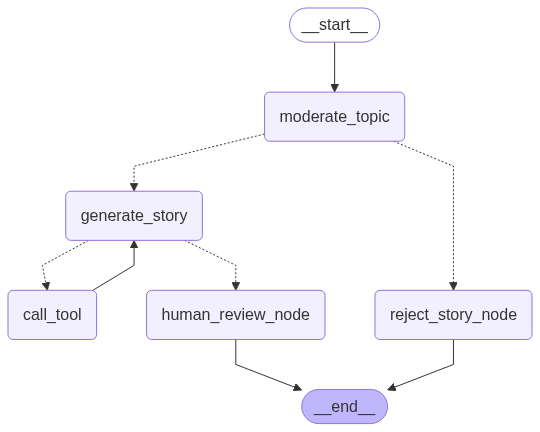

In [84]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)